In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Concatenate, Dropout
from sklearn.model_selection import train_test_split
from transformers import ViTModel, ViTFeatureExtractor
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
import matplotlib.pyplot as plt
import torch
from tensorflow.keras.callbacks import EarlyStopping

/Users/prihandana/Developer/Deep Learning/Unsplash_Image_Scrapper/Unsplash_Image_Captioning/Scrapping/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Load the captions file
def load_data(caption_file, image_dir):
    with open(caption_file, 'r') as f:
        lines = f.readlines()
    captions = []
    image_paths = []
    for line in lines:
        img_path, caption = line.strip().split('\t')
        captions.append(caption)
        image_paths.append(os.path.join(image_dir, img_path))
    return image_paths, captions

In [4]:
# Load Hugging Face ViT model and feature extractor
def load_vit_model_and_processor():
    model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
    model.eval()  # Set model to evaluation mode
    feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
    return model, feature_extractor

In [5]:
# Preprocess images for ViT
def preprocess_image_vit(image_path, feature_extractor):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")  # Convert to tensor
    return inputs["pixel_values"]

In [6]:
# Extract features using ViT
def extract_features_vit(image_paths, model, feature_extractor):
    features = []
    for path in image_paths:
        pixel_values = preprocess_image_vit(path, feature_extractor)
        with torch.no_grad():
            outputs = model(pixel_values)
            features.append(outputs.last_hidden_state.mean(dim=1).numpy())  # Take mean of all patches
    return np.vstack(features)

In [7]:
# Prepare tokenizer
def prepare_tokenizer(captions):
    tokenizer = Tokenizer(oov_token="<unk>")
    
    # Add <start> and <end> tokens to captions before fitting
    captions_with_tokens = ["<start> " + c + " <end>" for c in captions]
    
    tokenizer.fit_on_texts(captions_with_tokens)
    
    # Explicitly add <pad> to the tokenizer's vocabulary
    tokenizer.word_index["<pad>"] = 0
    tokenizer.index_word[0] = "<pad>"
    
    return tokenizer

In [ ]:
# Trim captions to max_len - 2
def trim_caption(caption, max_len):
    # Split caption into tokens
    caption_tokens = caption.split()
    
    # Trim tokens to fit within max_len - 2
    if len(caption_tokens) > max_len - 2:
        caption_tokens = caption_tokens[:max_len - 2]
    
    return caption_tokens

# Add <start> and <end> tokens to captions
def add_tokens(caption_tokens):
    return ["<start>"] + caption_tokens + ["<end>"]

# Pad captions 
def pad_caption(caption_tokens, max_len):
    # Add <pad> tokens to the end of captions shorter than max_len
    padding_needed = max_len - len(caption_tokens)
    return caption_tokens + ["<pad>"] * padding_needed

In [ ]:
def process_captions(captions, max_len):
    processed_captions = []
    
    for caption in captions:
        # Trim the caption
        caption_tokens = trim_caption(caption, max_len)
        
        # Add <start> and <end> tokens
        caption_tokens_with_tokens = add_tokens(caption_tokens)
        
        # Pad the caption to max_len
        caption_tokens_padded = pad_caption(caption_tokens_with_tokens, max_len)
        
        processed_captions.append(" ".join(caption_tokens_padded))
    
    return processed_captions

In [62]:
# Prepare sequences
def prepare_sequences(captions, tokenizer, max_len):
    # Process captions with trimming, token addition, and padding
    processed_captions = process_captions(captions, max_len)
    
    # Convert processed captions to sequences
    sequences = tokenizer.texts_to_sequences(processed_captions)
    
    # Ensure sequences are padded to max_len
    sequences = pad_sequences(sequences, padding="post", maxlen=max_len)
    
    # print processed captions and their tokenized sequences
    for i, caption in enumerate(processed_captions[7:8]): 
        print(f"Processed Caption {i + 1}: {caption}")
        print(f"Tokenized Sequence {i + 1}: {sequences[i]}")
        
    return sequences

In [44]:
def create_model(embedding_dim, lstm_units, vocab_size, max_len):
    # Image feature input
    image_input = Input(shape=(768,))
    image_embedding = Dense(embedding_dim, activation="relu")(image_input)
    image_embedding = Dropout(0.3)(image_embedding)  # Regularization
    image_embedding = Dense(embedding_dim, activation="relu")(image_embedding)

    # Text input
    text_input = Input(shape=(max_len - 1,))
    text_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(text_input)

    # Stacked LSTM layers
    lstm = LSTM(lstm_units, return_sequences=True)(text_embedding)
    lstm = Dropout(0.3)(lstm)  # Regularization
    lstm = LSTM(lstm_units, return_sequences=True)(lstm)

    # Combine image features and LSTM output
    combined = Add()([image_embedding, lstm])  # Combine image and text features

    # Output layer
    output = Dense(vocab_size, activation="softmax")(combined)

    # Create model
    model = Model(inputs=[image_input, text_input], outputs=output)
    return model

In [13]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title("Accuracy")

    plt.show()

In [14]:
caption_file = "Images/captions.txt"  # Path to caption.txt
image_dir = "Images/"  # Directory containing images
image_paths, captions = load_data(caption_file, image_dir)

In [15]:
# Load Hugging Face ViT model and feature extractor
vit_model, feature_extractor = load_vit_model_and_processor()
image_features = extract_features_vit(image_paths, vit_model, feature_extractor)

/Users/prihandana/Developer/Deep Learning/Unsplash_Image_Scrapper/Unsplash_Image_Captioning/Scrapping/.venv/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [63]:
max_len = 20

# Prepare tokenizer
tokenizer = prepare_tokenizer(captions)

# Prepare sequences with correct max_len
sequences = prepare_sequences(captions, tokenizer, max_len)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

Processed Caption 1: <start> high-angle photo of beach <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Tokenized Sequence 1: [  4  43  36   6 348 146   2   1   1   1   1   1   1   1   1   1   1   1
   1   1]


In [47]:
max_len

20

In [48]:
# Split data into training, validation, and testing
X_train_img, X_test_img, y_train, y_test = train_test_split(image_features, sequences, test_size=0.2, random_state=42)
X_train_img, X_val_img, y_train, y_val = train_test_split(X_train_img, y_train, test_size=0.2, random_state=42)

# Create input and target sequences
X_train_text, y_train_target = y_train[:, :-1], y_train[:, 1:]
X_val_text, y_val_target = y_val[:, :-1], y_val[:, 1:]
X_test_text, y_test_target = y_test[:, :-1], y_test[:, 1:]

# Flatten target sequences
y_train_target = y_train_target.reshape(-1, max_len - 1)  # Reshape for the target sequence
y_val_target = y_val_target.reshape(-1, max_len - 1)
y_test_target = y_test_target.reshape(-1, max_len - 1)


In [49]:
# Create model
embedding_dim = 512
lstm_units = 512
# Create the model
model = create_model(embedding_dim, lstm_units, vocab_size, max_len)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(loss=loss, optimizer=Adam(), metrics=["accuracy"])

In [50]:
print("X_train_text shape:", X_train_text.shape)  # Should be (num_samples, max_len - 1)
print("y_train_target shape:", y_train_target.shape)  # Should match X_train_text

X_train_text shape: (10229, 19)
y_train_target shape: (10229, 19)


In [51]:
print("X_train_img shape:", X_train_img.shape)
print("X_train_text shape:", X_train_text.shape)
print("y_train_target shape:", y_train_target.shape)
print("Model output shape:", model.output_shape)

X_train_img shape: (10229, 768)
X_train_text shape: (10229, 19)
y_train_target shape: (10229, 19)
Model output shape: (None, 19, 3124)


In [52]:
# Define early stopping callback
# Pakai next time aja
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=5,              # Number of epochs to wait for improvement
    mode='max',              # We want to maximize accuracy
    restore_best_weights=True  # Restore the weights of the best epoch
)

sample_weight = tf.cast(y_train_target != 0, tf.float32)

# Model fitting with the EarlyStopping callback
history = model.fit(
    [X_train_img, X_train_text], y_train_target,
    validation_data=([X_val_img, X_val_text], y_val_target),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping],
    sample_weight=sample_weight
)

Epoch 1/50


/Users/prihandana/Developer/Deep Learning/Unsplash_Image_Scrapper/Unsplash_Image_Captioning/Scrapping/.venv/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_42', 'keras_tensor_46']. Received: the structure of inputs=('*', '*')
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5789 - loss: 3.1050 - val_accuracy: 0.6564 - val_loss: 1.8048
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.6696 - loss: 1.6952 - val_accuracy: 0.7333 - val_loss: 1.3154
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.7480 - loss: 1.1719 - val_accuracy: 0.7676 - val_loss: 1.1008
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.7783 - loss: 0.9551 - val_accuracy: 0.7804 - val_loss: 1.0251
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.7967 - loss: 0.8281 - val_accuracy: 0.7870 - val_loss: 0.9860
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.8108 - loss: 0.7383 - val_accuracy: 0.7927 - val_loss: 0.9717
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.8242 - loss: 0.6648 - val_accuracy: 0.7949 - val_loss: 0.9618
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.8369 - loss: 0.5995 - val_accuracy: 

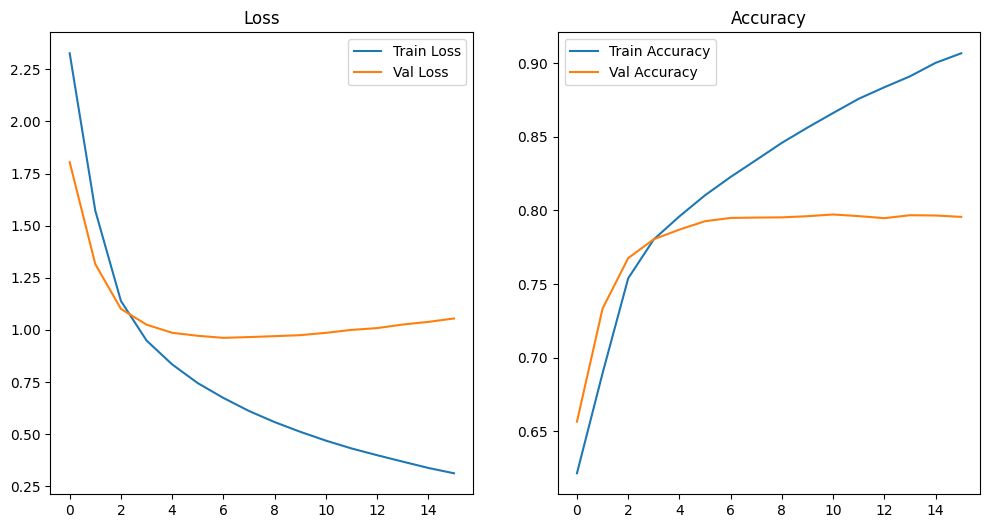

In [53]:
# Plot training history
plot_history(history)

In [ ]:
# Save the model
model.save("models/Vit_LSTM_6.h5")
print("Model saved")

Model saved


In [ ]:
# Save tokenizer
with open("tokenizer/tokenizer_6.json", "w") as f:
    f.write(tokenizer.to_json())
print("Tokenizer saved")

Tokenizer saved
